<a href="https://colab.research.google.com/github/mmaithani/data-science/blob/main/demo_3ddfa_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## A simple demostration of how to run

In [ ]:
# if not clone, clone it
%cd /content
!git clone https://github.com/cleardusk/3DDFA_V2.git
%cd 3DDFA_V2

In [ ]:
!sh ./build.sh

In [3]:
# before import, make sure FaceBoxes and Sim3DR are built successfully, e.g.,

import cv2
import yaml

from FaceBoxes import FaceBoxes
from TDDFA import TDDFA
from utils.render import render
from utils.depth import depth
from utils.pncc import pncc
from utils.uv import uv_tex
from utils.pose import viz_pose
from utils.serialization import ser_to_ply, ser_to_obj
from utils.functions import draw_landmarks, get_suffix

import matplotlib.pyplot as plt
from skimage import io

### Load configs

In [ ]:
# load config
cfg = yaml.load(open('configs/mb1_120x120.yml'), Loader=yaml.SafeLoader)

# Init FaceBoxes and TDDFA, recommend using onnx flag
onnx_flag = True  # or True to use ONNX to speed up
if onnx_flag:
    !pip install onnxruntime
    
    import os
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
    os.environ['OMP_NUM_THREADS'] = '4'
    from FaceBoxes.FaceBoxes_ONNX import FaceBoxes_ONNX
    from TDDFA_ONNX import TDDFA_ONNX

    face_boxes = FaceBoxes_ONNX()
    tddfa = TDDFA_ONNX(**cfg)
else:
    face_boxes = FaceBoxes()
    tddfa = TDDFA(gpu_mode=False, **cfg)

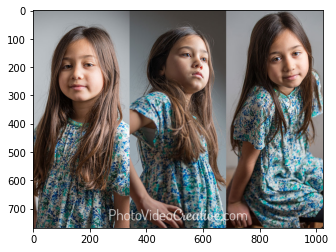

In [6]:
# given an image path or the image url

# img_fp = 'examples/inputs/emma.jpg'
# img = cv2.imread(img_fp)
# plt.imshow(img[..., ::-1])

img_url = 'https://photovideocreative.com/wordpress/wp-content/uploads/2017/12/Angles-de-prise-de-vue-horizontal-contreplong%C3%A9-et-plong%C3%A9.jpg'
img = io.imread(img_url)
plt.imshow(img)

img = img[..., ::-1]  # RGB -> BGR

### Detect faces using FaceBoxes

In [ ]:
# face detection
boxes = face_boxes(img)
print(f'Detect {len(boxes)} faces')
print(boxes)

### Regressing 3DMM parameters, reconstruction and visualization

In [8]:
# regress 3DMM params
param_lst, roi_box_lst = tddfa(img, boxes)

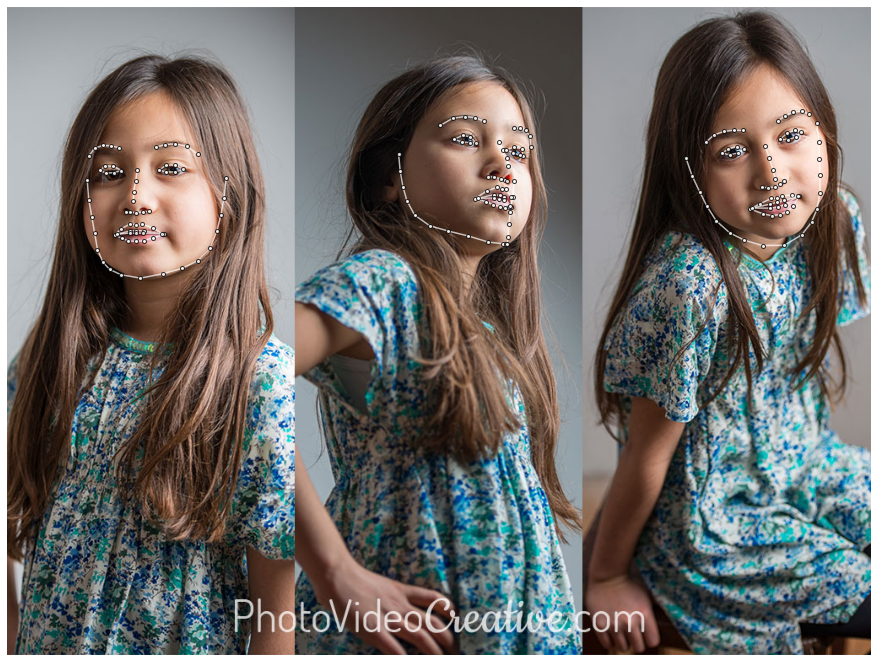

In [9]:
# reconstruct vertices and visualizing sparse landmarks
dense_flag = False
ver_lst = tddfa.recon_vers(param_lst, roi_box_lst, dense_flag=dense_flag)
draw_landmarks(img, ver_lst, dense_flag=dense_flag)

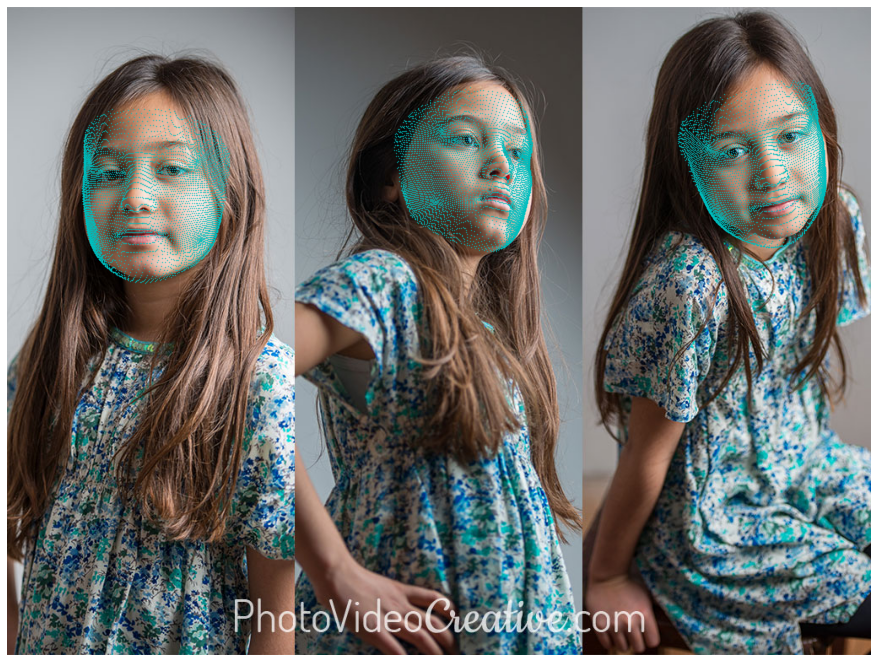

In [10]:
# reconstruct vertices and visualizing dense landmarks
dense_flag = True
ver_lst = tddfa.recon_vers(param_lst, roi_box_lst, dense_flag=dense_flag)
draw_landmarks(img, ver_lst, dense_flag=dense_flag)

In [ ]:
# reconstruct vertices and render
ver_lst = tddfa.recon_vers(param_lst, roi_box_lst, dense_flag=dense_flag)
render(img, ver_lst, tddfa.tri, alpha=0.6, show_flag=True);

In [ ]:
# reconstruct vertices and render depth
ver_lst = tddfa.recon_vers(param_lst, roi_box_lst, dense_flag=dense_flag)
depth(img, ver_lst, tddfa.tri, show_flag=True);

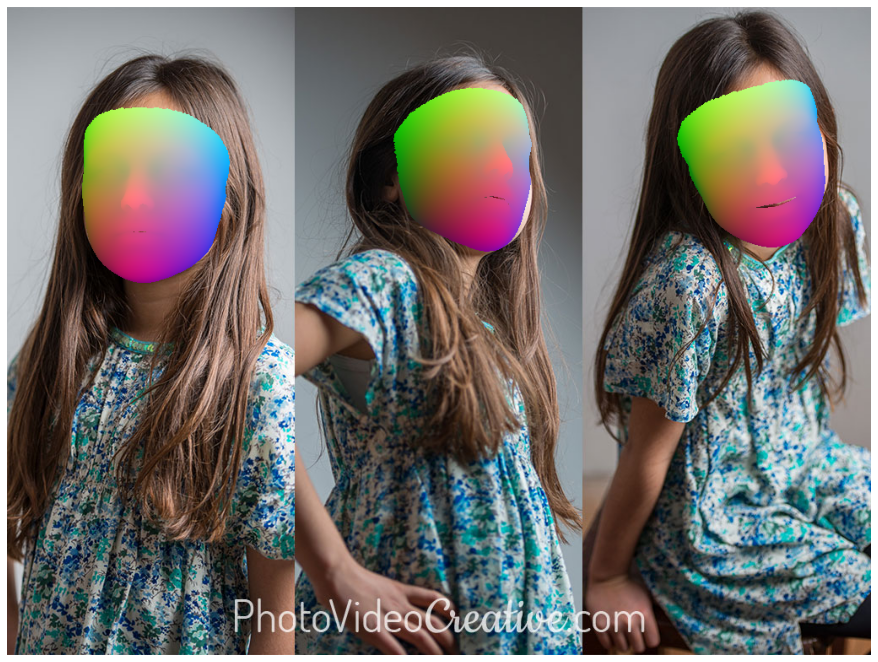

In [13]:
# reconstruct vertices and render pncc
ver_lst = tddfa.recon_vers(param_lst, roi_box_lst, dense_flag=dense_flag)
pncc(img, ver_lst, tddfa.tri, show_flag=True);

In [ ]:
# running offline
%%bash
for OPT in 2d_sparse 2d_dense 3d depth pncc pose uv_tex ply obj; do
  python demo.py -f examples/inputs/trump_hillary.jpg -o $OPT --show_flag=false --onnx;
done;